<a href="https://colab.research.google.com/github/vncntprvst/tools/blob/master/demo_pipeline_voltage_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Demo pipeline for processing voltage imaging data. The processing pipeline
# includes motion correction, memory mapping, segmentation, denoising and source
# extraction. The demo shows how to construct the params, MotionCorrect and VOLPY 
# objects and call the relevant functions. 
# Dataset courtesy of Karel Svoboda Lab (Janelia Research Campus).

In [ ]:
# Clone CaImAn from Github
!git clone https://github.com/flatironinstitute/CaImAn.git
%cd /content/CaImAn

Cloning into 'CaImAn'...
remote: Enumerating objects: 25304, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 25304 (delta 0), reused 0 (delta 0), pack-reused 25303
Receiving objects: 100% (25304/25304), 515.88 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (16982/16982), done.
Updating files: 100% (318/318), done.
/content/CaImAn


In [ ]:
# Install relevant packages
!pip install -r requirements.txt
! pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.6/126.6 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.1/966.1 KB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0

In [ ]:
# Install CaImAn package
!pip install -e . 
# Install CaImAn manager for relevant datasets
!python caimanmanager.py install --inplace
# Downgrade tensorflow to use Mask R-CNN


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CaImAn
  Preparing metadata (setup.py) ... done
  Running setup.py develop for caiman
Installed /root/caiman_data


In [ ]:
# Import packages
import os
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import h5py
import imageio
from IPython.display import HTML, display, clear_output

from base64 import b64encode

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.utils.utils import download_demo, download_model
from caiman.source_extraction.volpy import utils
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.source_extraction.volpy.mrcnn import visualize, neurons
import caiman.source_extraction.volpy.mrcnn.model as modellib
from caiman.summary_images import local_correlations_movie_offline
from caiman.summary_images import mean_image
from caiman.paths import caiman_datadir

# Set up the logger (optional); change this if you like.
# You can log to a file using the filename parameter, or make the output more
# or less verbose by setting level to logging.DEBUG, logging.INFO,
# logging.WARNING, or logging.ERROR
logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]" \
                    "[%(process)d] %(message)s",
                    level=logging.INFO)

In [ ]:
# Load demo movie and ROIs
# file path to movie file (will download if not present)
fnames = download_demo('demo_voltage_imaging.hdf5', 'volpy') 
# file path to ROIs file (will download if not present)
path_ROIs = download_demo('demo_voltage_imaging_ROIs.hdf5', 'volpy')  

# Setup some parameters for data and motion correction
# dataset parameters
fr = 400                                        # sample rate of the movie
ROIs = None                                     # Region of interests
index = None                                    # index of neurons
weights = None                                  # reuse spatial weights by 
                                                # opts.change_params(params_dict={'weights':vpy.estimates['weights']})
# motion correction parameters
pw_rigid = False                                # flag for pw-rigid motion correction
gSig_filt = (3, 3)                              # size of filter, in general gSig (see below),
                                                # change this one if algorithm does not work
max_shifts = (5, 5)                             # maximum allowed rigid shift
strides = (48, 48)                              # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)                             # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3                         # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'

opts_dict = {
    'fnames': fnames,
    'fr': fr,
    'index': index,
    'ROIs': ROIs,
    'weights': weights,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = volparams(params_dict=opts_dict)

In [ ]:
# Display the movie
# save the movie in the .mp4 format
m_orig = cm.load(fnames)
ds_ratio = 0.2
moviehandle = m_orig.resize(1, 1, ds_ratio)
min_, max_ = np.min(moviehandle), np.max(moviehandle)
moviehandle = np.array((moviehandle-min_)/(max_-min_)*255,dtype='uint8')
imageio.mimwrite('/root/caiman_data/raw_movie.mp4', moviehandle , fps = 60, quality=8)

# play the movie
mp4 = open('/root/caiman_data/raw_movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
 # %% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [ ]:
# MOTION CORRECTION
# Create a motion correction object with the specified parameters
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
# Run piecewise rigid motion correction
mc.motion_correct(save_movie=True)
dview.terminate()

In [ ]:
# motion correction compared with original movie
m_orig = cm.load(fnames)
m_rig = cm.load(mc.mmap_file)
m_orig.fr = 400
m_rig.fr = 400
ds_ratio = 0.2
moviehandle = cm.concatenate([m_orig.resize(1, 1, ds_ratio) - mc.min_mov * mc.nonneg_movie,
                              m_rig.resize(1, 1, ds_ratio)], axis=2)
min_, max_ = np.min(moviehandle), np.max(moviehandle)
moviehandle = np.array((moviehandle-min_)/(max_-min_)*255,dtype='uint8')
imageio.mimwrite('/root/caiman_data/motion_correction_movie.mp4', moviehandle , fps = 60, quality=8)

mp4 = open('/root/caiman_data/motion_correction_movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# part of movie subtracted baseline
m_rig2 = m_rig.computeDFF(secsWindow=1)[0][:1000]
moviehandle1 = -m_rig2
min_, max_ = np.min(moviehandle1), np.max(moviehandle1)
moviehandle1 = np.array((moviehandle1-min_)/(max_-min_)*255,dtype='uint8')
imageio.mimwrite('/root/caiman_data/motion_correction_bl_movie.mp4', moviehandle1 , fps = 60, quality=8)

mp4 = open('/root/caiman_data/motion_correction_bl_movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# Memory Mapping
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0
fname_new = cm.save_memmap_join(mc.mmap_file, base_name='memmap_',
                           add_to_mov=border_to_0, dview=dview, n_chunks=10)
dview.terminate()

# change fnames to the new motion corrected one
opts.change_params(params_dict={'fnames': fname_new})    

Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_ri

In [ ]:
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /root/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap


Text(0.5, 1.0, 'corr image')

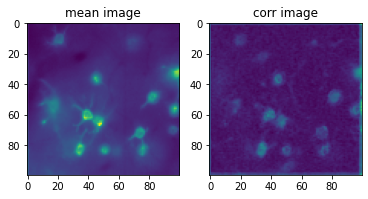

In [ ]:
# %% SEGMENTATION
# create summary images
img = mean_image(mc.mmap_file[0], window = 1000, dview=dview)
img = (img-np.mean(img))/np.std(img)

gaussian_blur = False        # Use gaussian blur when there is too much noise in the video
Cn = local_correlations_movie_offline(mc.mmap_file[0], fr=fr, window=fr*4, 
                                      stride=fr*4, winSize_baseline=fr, 
                                      remove_baseline=True, gaussian_blur=gaussian_blur,
                                      dview=dview).max(axis=0)
img_corr = (Cn-np.mean(Cn))/np.std(Cn)
summary_images = np.stack([img, img, img_corr], axis=0).astype(np.float32)
# save summary images which are used in the VolPy GUI
cm.movie(summary_images).save(fnames[:-5] + '_summary_images.tif')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(summary_images[0]); axs[1].imshow(summary_images[2])
axs[0].set_title('mean image'); axs[1].set_title('corr image')

In [ ]:
# SEGMENTATION
# Create mean and correlation image
use_maskrcnn = True  # set to True to predict the ROIs using the mask R-CNN
if not use_maskrcnn:                 # use manual annotations
    with h5py.File(path_ROIs, 'r') as fl:
        ROIs = fl['mov'][()]  # load ROIs
else:
    weights_path = download_model('mask_rcnn')    
    ROIs = utils.mrcnn_inference(img=summary_images.transpose([1, 2, 0]), size_range=[5, 22],
                                  weights_path=weights_path, display_result=True) # size parameter decides size range of masks to be selected
    cm.movie(ROIs).save(fnames[:-5] + '_mrcnn_ROIs.hdf5')

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(summary_images[0]); axs[1].imshow(ROIs.sum(0))
    axs[0].set_title('mean image'); axs[1].set_title('masks')

In [ ]:
# %% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False, maxtasksperchild=1)

In [ ]:
# %% parameters for trace denoising and spike extraction
ROIs = ROIs                                   # region of interests
index = list(range(len(ROIs)))                # index of neurons
weights = None                                # if None, use ROIs for initialization; to reuse weights check reuse weights block 

template_size = 0.02                          # half size of the window length for spike templates, default is 20 ms 
context_size = 35                             # number of pixels surrounding the ROI to censor from the background PCA
visualize_ROI = False                         # whether to visualize the region of interest inside the context region
flip_signal = True                            # Important!! Flip signal or not, True for Voltron indicator, False for others
hp_freq_pb = 1 / 3                            # parameter for high-pass filter to remove photobleaching
clip = 100                                    # maximum number of spikes to form spike template
threshold_method = 'adaptive_threshold'       # adaptive_threshold or simple 
min_spikes= 10                                # minimal spikes to be found
pnorm = 0.5                                   # a variable deciding the amount of spikes chosen for adaptive threshold method
threshold = 3                                 # threshold for finding spikes only used in simple threshold method, Increase the threshold to find less spikes
do_plot = False                               # plot detail of spikes, template for the last iteration
ridge_bg= 0.01                                # ridge regression regularizer strength for background removement, larger value specifies stronger regularization 
sub_freq = 20                                 # frequency for subthreshold extraction
weight_update = 'ridge'                       # ridge or NMF for weight update
n_iter = 2                                    # number of iterations alternating between estimating spike times and spatial filters

opts_dict={'fnames': fname_new,
            'ROIs': ROIs,
            'index': index,
            'weights': weights,
            'template_size': template_size, 
            'context_size': context_size,
            'visualize_ROI': visualize_ROI, 
            'flip_signal': flip_signal,
            'hp_freq_pb': hp_freq_pb,
            'clip': clip,
            'threshold_method': threshold_method,
            'min_spikes':min_spikes,
            'pnorm': pnorm, 
            'threshold': threshold,
            'do_plot':do_plot,
            'ridge_bg':ridge_bg,
            'sub_freq': sub_freq,
            'weight_update': weight_update,
            'n_iter': n_iter}

opts.change_params(params_dict=opts_dict);    

In [ ]:
#%% TRACE DENOISING AND SPIKE DETECTION
vpy = VOLPY(n_processes=n_processes, dview=dview, params=opts)
vpy.fit(n_processes=n_processes, dview=dview)

In [ ]:
from matplotlib import markers
indexes = np.where(vpy.estimates['locality'])[0]

for i in range(len(indexes)):  
  fig = plt.figure(constrained_layout=True,figsize=(16,6))
  gs = fig.add_gridspec(1, 3)
  ax1 = fig.add_subplot(gs[:1])
  ax2 = fig.add_subplot(gs[1:])            
  #ax1.imshow(ROIs[indexes][i])  
  

  spatial = vpy.estimates['weights'][indexes][i].copy()
  ax1.imshow(img_corr, interpolation='None', cmap=plt.cm.gray, vmax=np.percentile(img_corr, 98))
  spatial[spatial == 0] = np.nan
  ax1.imshow(spatial, interpolation='None',
            alpha=0.5, cmap=plt.cm.hot)
  ax1.set_title(f'neuron {indexes[i]}')
  plt.axis('off')     
  ax2.plot(vpy.estimates['t'][indexes][i])
  ax2.plot(vpy.estimates['spikes'][indexes][i],
          np.max(vpy.estimates['t'][indexes][i]) * np.ones(vpy.estimates['spikes'][indexes][i].shape),
          color='r', marker='.', markersize=5, fillstyle='none', linestyle='none')
  ax2.legend(['trace', 'spikes'])

  display(fig)
  clear_output(wait=True)    
  plt.pause(0.5) 
 

In [ ]:
# STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)